In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

#os.chdir('D:/GANart/GAN-Artwork-Generation')

import torch.nn as nn
import torch.nn.functional as F
import torch

#os.makedirs("images", exist_ok=True)

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from parameters import *

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(n_class, n_class)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + n_class, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, noise_input, labels):
        # Concatenate label embedding and image to produce input
        #print(self.label_emb(labels).unsqueeze(2).unsqueeze(3).shape, noise_input.shape, labels.shape)
        gen_input = torch.cat((self.label_emb(labels).unsqueeze(2).unsqueeze(3), noise_input), 1)
        img = self.main(gen_input)
        img = img.view(img.size(0), *(nc, image_size, image_size))
        return img
    
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        #self.label_emb = nn.Embedding(n_class, n_class)
        self.label_emb = nn.Embedding(n_class, ndf*16*4)
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 2 x 2
            nn.Flatten()
        )
        self.linear = nn.Sequential(
        #nn.Linear(hp.critic_size * 8, hp.critic_hidden_size),
        #nn.LeakyReLU(0.2, inplace=True),   
        #nn.Linear(n_class + 1, 1),
        #nn.Sigmoid()
        
        #nn.Linear(n_class + ndf * 8 * 16, ndf),
        nn.Linear(ndf*16*4*2, ndf*16),    
        #nn.BatchNorm1d(ndf*16),
        nn.LeakyReLU(0.2, inplace=True),   
        nn.Linear(ndf*16, 1),
        nn.Sigmoid()    
        )

    def forward(self, input, labels):
        disc_out = self.main(input)
        #print(input.shape, labels.shape, self.label_emb(labels).shape, disc_out.shape)
        #linear_input = torch.cat((self.label_emb(labels).unsqueeze(2).unsqueeze(3), disc_out), 1)
        linear_input = torch.cat((self.label_emb(labels), disc_out), 1)
        linear_output = self.linear(linear_input.squeeze())
        #print(input.shape, labels.shape, disc_out.shape, linear_input.shape, linear_output.shape)
        return linear_output.unsqueeze(2).unsqueeze(3)

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create the dataloader
from dataloader_wikiart import *
dataloader = get_dataset()

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


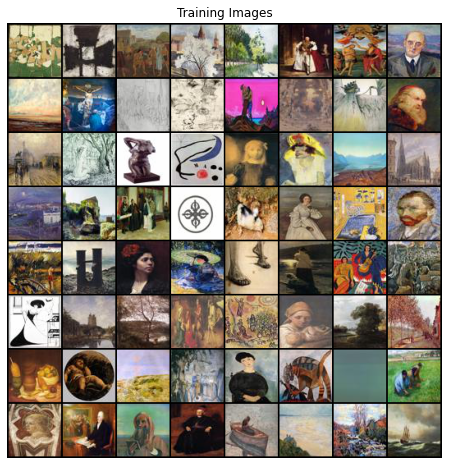

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (label_emb): Embedding(27, 27)
  (main): Sequential(
    (0): ConvTranspose2d(177, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

In [7]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (label_emb): Embedding(27, 2048)
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
example_size = 4
fixed_noise = torch.randn(n_class*example_size, nz, 1, 1, device=device)
fixed_label = torch.tensor(list(np.repeat([i for i in range(n_class)], example_size))).type(torch.LongTensor).to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
from torchvision.utils import save_image
img_save_path = 'images'
os.makedirs(img_save_path, exist_ok=True)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, real_style_labels) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # style labels - iso
        real_style_labels = real_style_labels.to(device)
        fake_style_labels = torch.tensor(np.random.choice(n_class, size = b_size)).type(torch.LongTensor).to(device)
        # Forward pass real batch through D
        output = netD(real_cpu, real_style_labels).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, fake_style_labels)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), fake_style_labels).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, fake_style_labels).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        #if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        if (i == len(dataloader)-1):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_label).detach().cpu()
            img_list.append(vutils.make_grid(fake, nrow = example_size,padding=2, normalize=True))
            save_image(fake.data, img_save_path + '/%d-%d.png' % (epoch,iters), nrow=example_size, normalize=True)

        iters += 1

Starting Training Loop...
[0/150][0/1273]	Loss_D: 1.3910	Loss_G: 0.9173	D(x): 0.4817	D(G(z)): 0.4803 / 0.4029
[0/150][200/1273]	Loss_D: 0.6699	Loss_G: 3.0078	D(x): 0.7766	D(G(z)): 0.2607 / 0.0854
[0/150][400/1273]	Loss_D: 0.5181	Loss_G: 3.4447	D(x): 0.7488	D(G(z)): 0.0784 / 0.0594
[0/150][600/1273]	Loss_D: 0.3931	Loss_G: 3.6480	D(x): 0.8173	D(G(z)): 0.0923 / 0.0470
[0/150][800/1273]	Loss_D: 0.8432	Loss_G: 3.2206	D(x): 0.6369	D(G(z)): 0.1337 / 0.0976
[0/150][1000/1273]	Loss_D: 0.3077	Loss_G: 4.3294	D(x): 0.9258	D(G(z)): 0.1720 / 0.0276
[0/150][1200/1273]	Loss_D: 0.5273	Loss_G: 3.9421	D(x): 0.8764	D(G(z)): 0.1992 / 0.0378
[1/150][0/1273]	Loss_D: 0.5058	Loss_G: 3.3205	D(x): 0.8222	D(G(z)): 0.1878 / 0.0592
[1/150][200/1273]	Loss_D: 0.5522	Loss_G: 4.3634	D(x): 0.9377	D(G(z)): 0.2765 / 0.0298
[1/150][400/1273]	Loss_D: 0.8022	Loss_G: 3.2144	D(x): 0.6931	D(G(z)): 0.1875 / 0.1010
[1/150][600/1273]	Loss_D: 0.8785	Loss_G: 4.0627	D(x): 0.8281	D(G(z)): 0.3625 / 0.0343
[1/150][800/1273]	Loss_D: 0.43

In [ ]:
# Plot Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(25,25))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Real vs Fake
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
## Visualize G's Progress
#fig = plt.figure(figsize=(10,10))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
##ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
#ani = animation.ArtistAnimation(fig, [ims[i] for i in np.arange(0, len(ims), 11)], interval=1000, repeat_delay=1000, blit=True)
#
#HTML(ani.to_jshtml())

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(25,25))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[100],(1,2,0)))
plt.show()